In [1]:
import torch
import torchvision
from torchmetrics import Accuracy
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import random

from pathlib import Path
import zipfile
import requests
import os

from PIL import Image

from typing import Dict, List, Tuple

> #### Defining the paths

In [2]:
import sys
import importlib.util

modules_path = 'PyTorch Bootcamp--06 -Transfer Learning/'
sys.path.append(modules_path)
module_names = ['data_setup', 'engine']
modules = {}
for module_name in module_names:
    spec = importlib.util.find_spec(module_name)
    if spec is not None:
        modules[module_name] = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(modules[module_name])
    else:
        print(f"Module '{module_name}' not found.")

In [3]:
from data_setup import create_dataloaders
from engine import train_step, test_step

In [4]:
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'
image_paths_list = list(image_path.glob('*/*/*.jpg'))

train_path = image_path / 'train'
test_path = image_path / 'test'

In [6]:
manual_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor()])

In [7]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_path, test_dir=test_path, transform=manual_transforms, batch_size=32)

> ### Splitting data into patches and creating class, position and patch embeddings

> #### Plotting patched image for visualization

In [14]:
def plot_pathced_image(image_tensor, image_size=224, patch_size=16):
    permuted_image = image_tensor.permute(1, 2, 0)
    fig, axs = plt.subplots(nrows=image_size // patch_size,
                           ncols=image_size // patch_size,
                           sharex=True, sharey=True,
                           figsize=(patch_size, patch_size))
    for i, patch_height in enumerate(range(0, image_size, patch_size)):
        for j, patch_width in enumerate(range(0, image_size, patch_size)):
            axs[i, j].imshow(permuted_image[patch_height:patch_height + patch_size,
                                            patch_width:patch_width + patch_size, :])
            axs[i, j].set_ylabel(i+1, rotation='horizontal',
                                horizontalalignment='right',
                                verticalalignment='center')
            axs[i, j].set_xlabel(j+1)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].label_outer([])

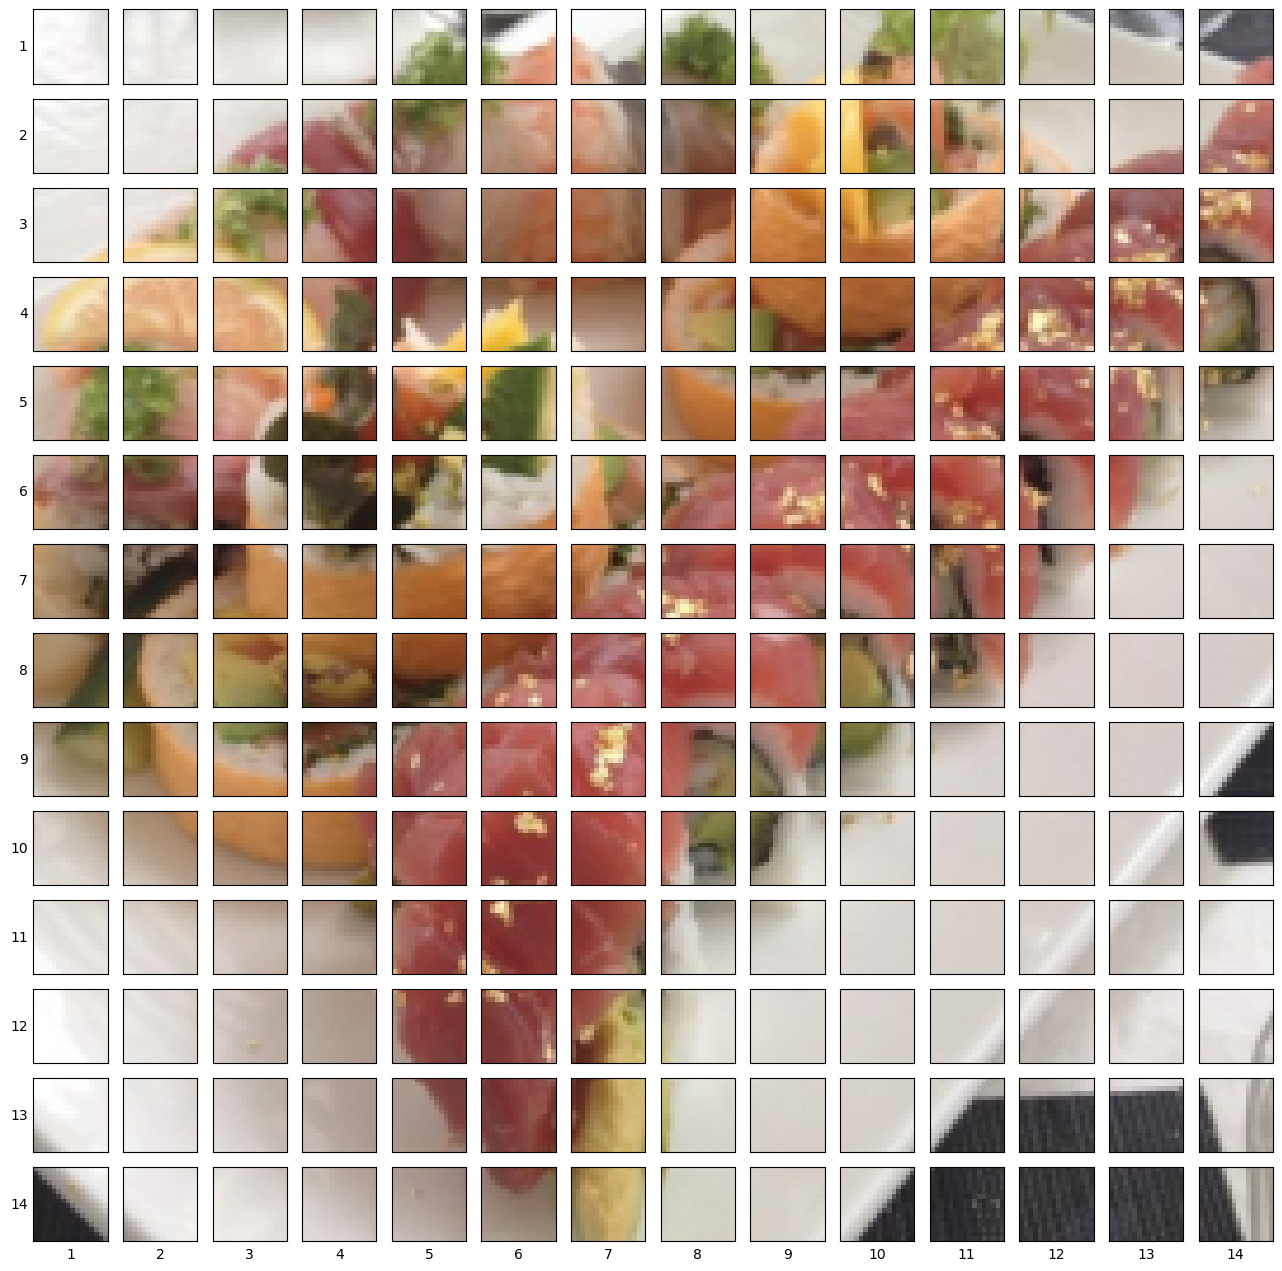

In [15]:
random_image_batch, random_labels_batch = next(iter(train_dataloader))
random_image = random_batch[0]
plot_pathced_image(random_image)

> #### Class for embeddings

This class handles:
+ Path embedding
+ Class token embedding
+ Position embedding

In [72]:
class Embeddings(nn.Module):
    def __init__(self, in_channels=3, image_resolution = 224,
                 patch_size=16, embedding_dim=768):
        super().__init__()
    
        self.no_of_patches = (image_resolution ** 2) // (patch_size ** 2)
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
        
    
    def get_patch_embeddings(self, x):
        return (self.flatten(self.patcher(x))).permute(0, 2, 1)
    
    def get_class_token_embeddings(self, x):
        return nn.Parameter(torch.randn(x.shape[0], 1, embedding_dim), requires_grad=True)
    
    def get_position_embeddings(self, x):
        return nn.Parameter(torch.randn(x.shape[0], self.no_of_patches + 1,
                                        embedding_dim), requires_grad=True)
        
    
    def forward(self, x):
        return (torch.cat([self.get_patch_embeddings(x),
                           self.get_class_token_embeddings(x)], dim=1)
                + self.get_position_embeddings(x))

In [77]:
embeddings = Embeddings()
embeddings(random_batch).shape

torch.Size([32, 197, 768])